## Load Packages 

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.insert(1, '../../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.classification import predict_xr
from dea_tools.dask import create_local_dask_cluster

import warnings
warnings.filterwarnings("ignore")


## Set up a dask cluster

In [2]:
create_local_dask_cluster(spare_mem='2Gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/chad.burton@anu.edu.au/proxy/8787/status,
Dashboard: /user/chad.burton@anu.edu.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 13.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43459,Workers: 1
Dashboard: /user/chad.burton@anu.edu.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 13.14 GiB
Comm: tcp://127.0.0.1:35215,Total threads: 2
Dashboard: /user/chad.burton@anu.edu.au/proxy/45539/status,Memory: 13.14 GiB
Nanny: tcp://127.0.0.1:37101,


## Analysis parameters

In [14]:
model_path = 'rf_fmc.pickle'

testing_locations = {
    'Namadgi': (-35.675, 149.0540),  
    'Mallacoota': (-37.5162, 149.6735),
    # 'Geraldton': (-28.850, 114.746),
    # 'Ravensthorpe': (-33.5048, 119.839),
}

buffer = 0.15

output_crs='EPSG:3577'

dask_chunks = {'x': 1000, 'y': 1000}

time= ('2020-05-01', '2020-06-30')

resolution = (-20, 20)

measurements =  ["nbart_red","nbart_green","nbart_blue",
                 "nbart_nir_1","nbart_nir_2",
                "nbart_swir_2","nbart_swir_3"
                ]

## Connect to the datacube

In [15]:
dc = datacube.Datacube(app='fmc')

## Import the model

In [16]:
model = load(model_path).set_params(n_jobs=1)

## Set up datacube query


In [17]:
# Generate a new datacube query object
query = {
    'time': time,
    'resolution': resolution,
    'output_crs': output_crs,
    'dask_chunks': dask_chunks,
    'measurements': measurements
}

## Loop through test locations and predict

In [18]:
predictions = []

for key, value in testing_locations.items():

    print('Working on: ' + key)
    
    bounds = {'x': (value[1] - buffer, value[1] + buffer),
              'y': (value[0] + buffer, value[0] - buffer)}
    
    # Update datacube query

    query.update(bounds)

    # Load data and calculate features
    ds = load_ard(dc=dc,
              products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
              cloud_mask="s2cloudless",
              mask_pixel_quality=True,
              min_gooddata=0.9,
              **query)
    
    ds['ndvi']=((ds.nbart_nir_1-ds.nbart_red)/(ds.nbart_nir_1+ds.nbart_red))
    ds['ndii']=((ds.nbart_nir_1-ds.nbart_swir_2)/(ds.nbart_nir_1+ds.nbart_swir_2))
    
    # ensure 
    ds = ds[['ndvi','ndii','nbart_red','nbart_green','nbart_blue',
             'nbart_nir_1','nbart_nir_2','nbart_swir_2','nbart_swir_3']]
    
    ds = ds.isel(time=0)
    
    # Predict using the imported model
    predicted = predict_xr(model,
                           ds,
                           proba=False,
                           persist=False,
                           clean=True,
                           return_input=True).compute()

    predictions.append(predicted)
    

Working on: Namadgi
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 5 out of 13 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Returning 5 time steps as a dask array
predicting...
   input features...
Working on: Mallacoota
Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 4 out of 16 time steps with at least 90.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Returning 4 time steps as a dask array
predicting...
   input features...


## Create colormap consistent with the current Australian Fuel Monitoring System

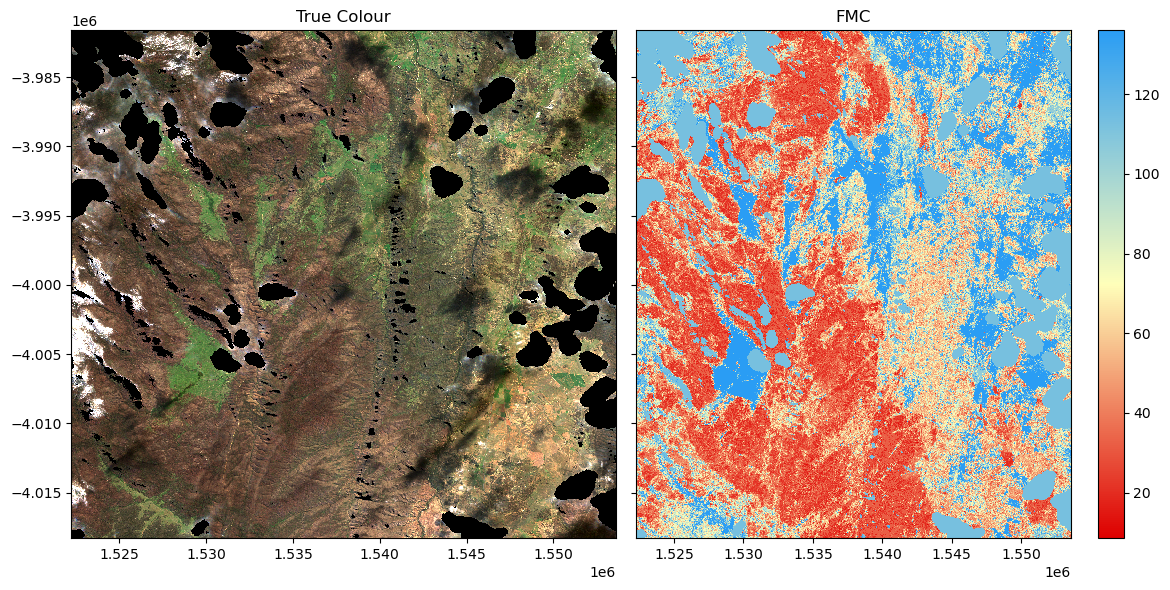

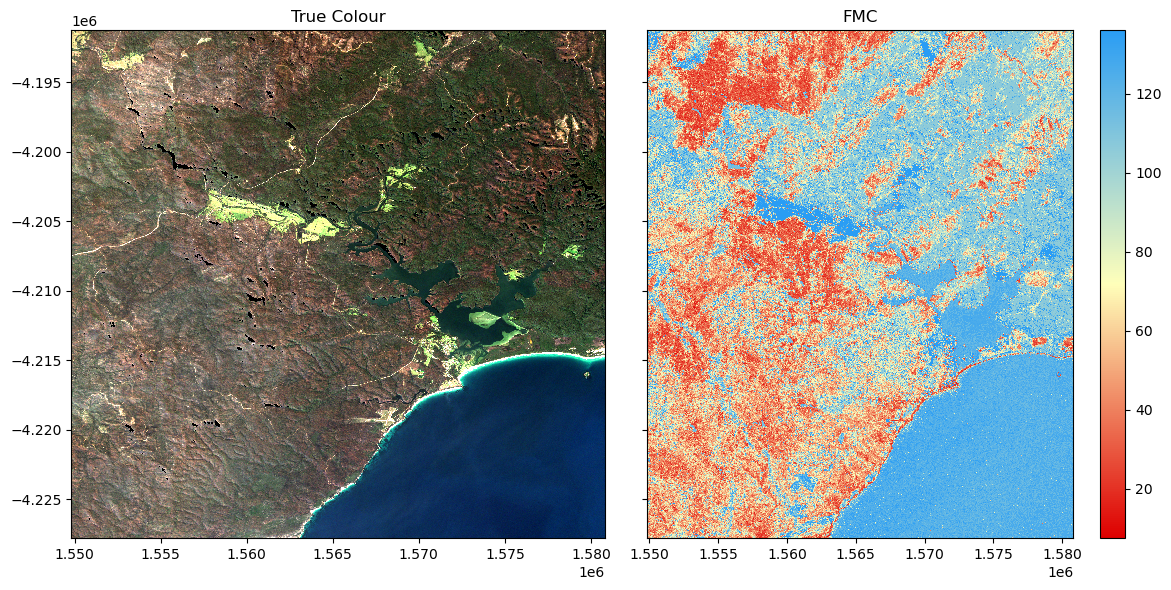

In [19]:
colors = [(0.87, 0, 0), (1, 1, 0.73), (0.165, 0.615, 0.957)] 
cmap = LinearSegmentedColormap.from_list('fmc', colors, N=256)

for i in range(0, len(predictions)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # Plot true colour image
    rgb(predictions[i],
        bands=['nbart_red', 'nbart_green', 'nbart_blue'],
        ax=axes[0],
        percentile_stretch=(0.01, 0.99),
        add_labels=False
       )

    # Plot classified image
    np.clip(predictions[i].Predictions, 0, 136).plot(ax=axes[1],
                                    cmap=cmap,
                                    add_labels=False,
                                    add_colorbar=True)

    # Add plot titles
    axes[0].set_title('True Colour')
    axes[1].set_title('FMC')
    plt.tight_layout();